# Overview of Hypothesis Testing
---
A statistical method to evaluate whether data supports or contradicts a particular **Hypothesis**. In the context of the medical insurance dataset, we'll be exploring the relationships between various factors like age, bmi, smoker, medical charges etc.

We'll be stating Null Hypothesis (H0) & Alternative Hypothesis (H1). Running different Hypothesis using T-Test, Chi-Square Test and Power Analysis. Through this, we can gain valuable insights like factors that influence healthcare costs and develop evidence-based policies and strategies.

![Image](https://miro.medium.com/v2/resize:fit:1400/1*dBkNWPenhrK2EwP3hGnEkw.jpeg)



In [2]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# importing dataset
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


To ensure the validity of our T-test, we'll assess the normality of our data using the Shapiro-Wilk test.

In [3]:

# defining shapiro normality Test
def shapiro_normality_test(x:pd.Series):
    """
    Performs the Shapiro-Wilk Normality Test to check whether 
    the given data follows normal distribution of not.
    """
    
    statistic,p_value = stats.shapiro(x)
    if p_value > 0.05:
        print("The data is normally distributed")
    else:
        print("The data is not normally distributed")

    print(f"statistic={statistic.round(decimals=3)}")
    print(f"p_value={p_value.round(decimals=3)}")
    

# Data Transformation
---

In [4]:
# categorizing the bmi values as underweight,normal,overweight and obsesity.
df.sort_values(by='bmi',ascending=True).reset_index(drop=True,inplace=True)

conditions = [
    (df['bmi']<18.5),                       #underweight
    (df['bmi']>=18.5) & (df['bmi']<=25),    #normal
    (df['bmi']>25) & (df['bmi']<=29.9),     #overweight 
    (df['bmi']>29.9)]                       #obesity 

categories = ['underweight','normal','overweight','obesity']

df['bmi_category'] = np.select(conditions,categories,default='unknown')


df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obesity
2,28,male,33.000,3,no,southeast,4449.46200,obesity
3,33,male,22.705,0,no,northwest,21984.47061,normal
4,32,male,28.880,0,no,northwest,3866.85520,overweight


In [5]:
df['bmi_category'].value_counts().to_frame().reset_index()

,bmi_category,count
0,obesity,716
1,overweight,375
2,normal,227
3,underweight,20


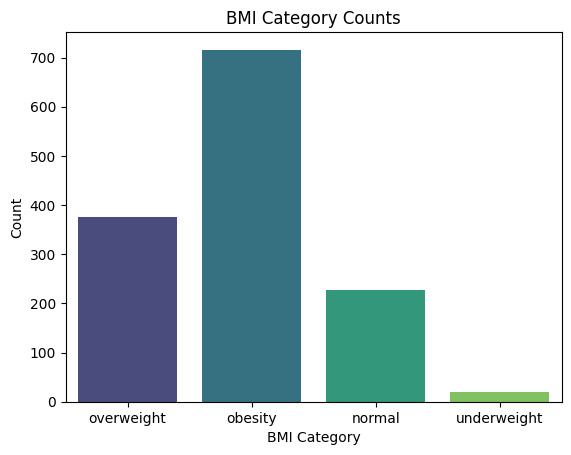

In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.countplot(x='bmi_category',data=df,palette="viridis")
plt.title('BMI Category Counts')
plt.xlabel('BMI Category')
plt.ylabel('Count') 
plt.show()


> **From the graph, Due to insufficient data points for the underweight category, we have excluded it from further analysis to ensure the reliability of our results.**

In [7]:
# extracting medical charges for each bmi category

normalweight_charges = df.query('bmi_category == "normal"')['charges']
overweight_charges = df.query('bmi_category == "overweight"')['charges']
obesity_charges = df.query('bmi_category == "obesity"')['charges']

# shapiro normality test for normal charges
shapiro_normality_test(normalweight_charges)
# shapiro normality test for overweight charges
shapiro_normality_test(overweight_charges)
# shapiro normality test for obesity charges
shapiro_normality_test(obesity_charges)    

The data is not normally distributed

statistic=0.918

p_value=0.0

The data is not normally distributed

statistic=0.899

p_value=0.0

The data is not normally distributed

statistic=0.805

p_value=0.0


>**The Shapiro-Wilk test indicates that the medical charges within each BMI category are not normally distributed. To address this, we'll use bootstrapping to create multiple resampled datasets from each category.**

In [8]:

def get_bootstrap_samples(data:pd.Series,n_resamples:int):
    """
    Generates bootstrap samples for given dataset

    Args:
        data:pd.Series
        n_resamples:int (total samples to generate)
    Returns:
        bootstrap_sample:numpy.ndarray
    """
    bootstrap_samples = stats.bootstrap(data=(data,),
                                        statistic=np.mean,
                                        confidence_level=0.95, # 5% significance level
                                        n_resamples=n_resamples,
                                        axis=0).bootstrap_distribution
    return bootstrap_samples

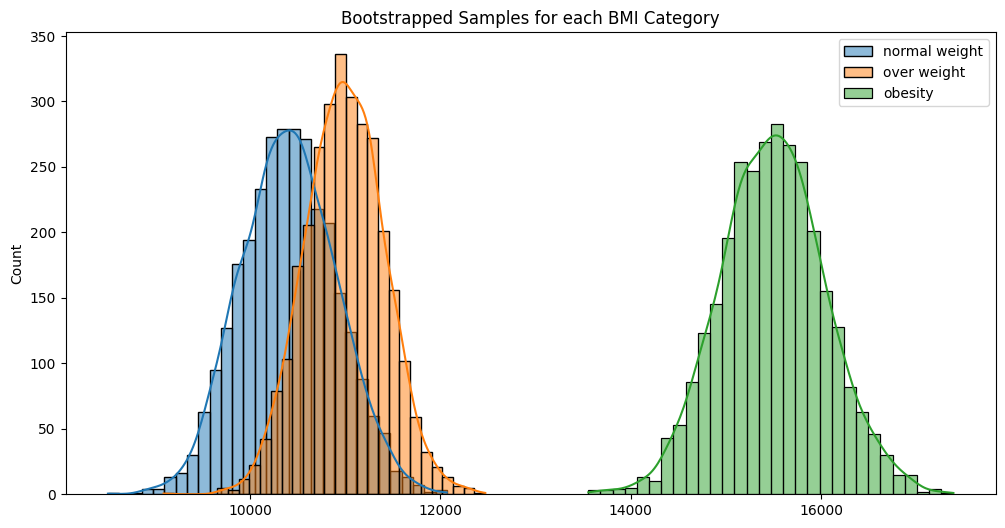

In [9]:
# get bootstrap samples for the charges based on bmi category
normalweight_bootstrap_samples = get_bootstrap_samples(normalweight_charges,3000)

overweight_bootstrap_samples = get_bootstrap_samples(overweight_charges,3000)

obesity_bootstrap_samples = get_bootstrap_samples(obesity_charges,3000)


# plot the histogram of the bootstrap samples
plt.figure(figsize=(12,6))
sns.histplot(normalweight_bootstrap_samples,bins=30,edgecolor='black',kde=True,label='normal weight')
sns.histplot(overweight_bootstrap_samples,bins=30,edgecolor='black',kde=True,label='over weight')
sns.histplot(obesity_bootstrap_samples,bins=30,edgecolor='black',kde=True,label='obesity')
plt.legend()
plt.title("Bootstrapped Samples for each BMI Category")
plt.show()


In [10]:
shapiro_normality_test(normalweight_bootstrap_samples)
shapiro_normality_test(overweight_bootstrap_samples)
shapiro_normality_test(obesity_bootstrap_samples)

The data is normally distributed

statistic=0.999

p_value=0.549

The data is normally distributed

statistic=0.999

p_value=0.536

The data is normally distributed

statistic=0.999

p_value=0.632


> **Shapiro-Wilk test results (p-value > 0.05) and visual inspection suggest normality of the bootstrapped charges within each BMI category.**

# One Sample T-Test
---
Assumptions:
1. Normality: Data is normally distributed
2. Independence: Data points are independent of each other
3. Randomness: Data is randomly sampled from the population
4. Representativeness: Data is representative of the population

---
### Formulating Hypotheis: **Is there a statistically significant difference between the population mean charge and the sample mean charges based on BMI category?**

**Null Hypothesis (H0)**: 
No statistically significant difference exists between the population and sample mean charges.

**Alternative Hypothesis (H1)**: 
A statistically significant difference exists between the population and sample mean charges.


In [11]:
# retrieving the population mean charges
pop_mean = df['charges'].mean()

# defining the function which performs T-Test
def one_sample_t_test(sample: pd.Series, pop_mean: float) -> tuple:
    """
    Performs a one-sample t-test to determine if there is a significant difference 
    between the population mean charges and the sample mean charges.

    Args:
        sample (pd.Series): A sample of data to compare to the population mean.
        pop_mean (float): The population mean to compare the sample to.
    """
    t_statistic, p_value = stats.ttest_1samp(sample, pop_mean)
    t_statistic = round(t_statistic, 3)
    p_value = round(p_value, 3)
    print(f"t_statistic={t_statistic}")
    print(f"p_value={p_value}")
    print(f"There is a {'no ' if p_value >= 0.05 else ''}significant difference "
          f"between the population mean charges and the sample mean charges.")


In [12]:
# one sample t-test for normal weight charges
one_sample_t_test(normalweight_bootstrap_samples,                 # sample data
                  pop_mean)                             # population mean


t_statistic=-314.764

p_value=0.0

There is a significant difference between the population mean charges and the sample mean charges.


In [13]:
# one sample t-test for overweight charges
one_sample_t_test(overweight_bootstrap_samples,pop_mean)


t_statistic=-300.898

p_value=0.0

There is a significant difference between the population mean charges and the sample mean charges.


In [14]:
# one sample t-test for obesity charges
one_sample_t_test(obesity_bootstrap_samples,pop_mean)

t_statistic=221.825

p_value=0.0

There is a significant difference between the population mean charges and the sample mean charges.


> **As compared to Population mean charges, the sample mean charges are statistically significant. Hence, we *reject* the null hypothesis (H0).**

# Two Sample T-Test (Test for Independence)
---
Assumptions:
1. Normality: Data is normally distributed
2. Independence: Data points are independent of each other
3. Randomness: Data is randomly sampled from the population
4. Representativeness: Data is representative of the population

### Formulating Hypothesis: **Is there a statistically significant difference between the medical charges for different bmi categories?**

**Null Hypothesis (H0)**: 
No statistically significant difference exists between the normality and overweight bmi categories medical charges.

**Alternative Hypothesis (H1)**: 
A statistically significant difference exists between the normality and overweight bmi categories medical charges.


In [15]:
# performing levene's test to check for equal variances
from scipy.stats import levene

statistic, p_value = levene(normalweight_bootstrap_samples, overweight_bootstrap_samples)

print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value.round())

Levene's test statistic: 93.20067043281352

Levene's test p-value: 0.0


> The equal variance b/w normal and obesity bootstrapped samples does not exist.

In [16]:
t_statistic,p_value = stats.ttest_ind(normalweight_bootstrap_samples,
                                      overweight_bootstrap_samples,
                                      equal_var=False)


print(f"t_statistic={t_statistic.round(decimals=3)}")
print(f"p_value={p_value.round(decimals=3)}")
if p_value < 0.05:
    print("There is a significant difference between the mean charges of normal weight and overweight")
else:
    print("There is no significant difference between the mean charges of normal weight and overweight")
    
    

t_statistic=-49.712

p_value=0.0

There is a significant difference between the mean charges of normal weight and overweight


> **At 95% confidence level, the p-value of the t-test is 0.001, indicating that there is a significant difference between the means of the two groups and the observed difference is very unlikely to occur by chance. Hence, we *reject* the null hypothesis.**

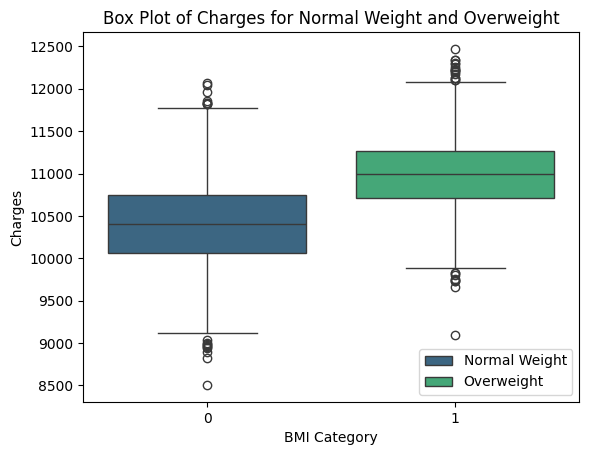

In [17]:
# comparing the box plots
sns.boxplot(data=[normalweight_bootstrap_samples,overweight_bootstrap_samples],
            showfliers=True,
            palette='viridis')
plt.legend(labels=['Normal Weight','Overweight'])
plt.title('Box Plot of Charges for Normal Weight and Overweight')
plt.xlabel('BMI Category')
plt.ylabel('Charges')
plt.show()



Calculating the Confidence Interval for the mean difference b/w normal & overweight bmi charges

In [18]:
# creating confidence interval for the difference between the means of the two groups

mean_diff = abs(normalweight_bootstrap_samples - overweight_bootstrap_samples)

confidence_interval = stats.t.interval(confidence=0.95,
                                       df=len(mean_diff)-1,
                                       loc=t_statistic,
                                       scale=stats.sem(mean_diff))
print(f"confidence interval={confidence_interval}")

confidence interval=(-67.4100497416585, -32.0137948742137)


> **Since, the confidence interval does not contain 0, we can conclude that there is a significant difference between the mean charges of normal weight and overweight**


# Power Analysis
---
![Image](https://www.spotfire.com/content/dam/spotfire/images/graphics/inforgraphics/updated-power-analysis-diagram.svg)

Calculating the effect size provides valuable insights into the practical significance of our findings. ``Cohen's d`` is a commonly used metric for effect size, which helps us determine whether the observed difference between the two groups is substantial and meaningful, beyond just being statistically significant."

In [19]:

# Assuming you have the mean, standard deviation, and sample size for each group

# calculating mean difference b/w normal and overweight bmi charges
mean_difference = abs(np.mean(normalweight_bootstrap_samples) - np.mean(overweight_bootstrap_samples))

# constructing pooled standard deviation
pooled_sd = np.sqrt(((len(normalweight_bootstrap_samples) - 1) * np.var(normalweight_bootstrap_samples) + (len(overweight_bootstrap_samples) - 1) * np.var(overweight_bootstrap_samples)) / (len(normalweight_bootstrap_samples) + len(overweight_bootstrap_samples) - 2))

# calculating cohens d
cohens_d = mean_difference / pooled_sd

print("Cohen's d:", cohens_d)

Cohen's d: 1.2837702942594484


> **The Cohen's d of 1.32 indicates a very large effect size, suggesting that the difference in insurance charges between normal weight and overweight individuals is substantial and not likely due to chance.**

In [20]:
from statsmodels.stats.power import tt_solve_power

# Assuming you have the effect size, significance level, and desired power
effect_size = 1.25  # Cohen's d
alpha = 0.05        # Significance level
power = 0.8         # Power

# Calculate the required sample size for each group
nobs = tt_solve_power(effect_size=effect_size, 
                      alpha=alpha,
                      power=power,
                      alternative='two-sided')

print("Required sample size per group:", nobs)

Required sample size per group: 7.171635310997964


> **With a desired power of 80%, i.e. an 80% proabability of correctly rejecting a false null hypothesis, the minimum required sample size for each category is approximately 7. Since our actual sample size exceeds this value, we can have confidence in the statistical power of our analysis.**

